# Unveiling Malicious Software with Anomaly Detection

In the ever-changing field of cybersecurity, the persistent challenge of malware detection continues to demand more sophisticated approaches day by day. Today, we will dive into an implementation of Density-Based Spatial Clustering of Applications with Noise (DBSCAN) for anomaly detection as a robust tool for identifying malicious softwares.  
  
In order to demonstrate the efficacy of DBSCAN in real-world scenarios, we will turn our attention to the TUNADROMD dataset. Comprising 4,465 instances and 241 features, this dataset details a collection of Android software samples. Every sample is classified as either 'malware' or 'goodware', with features 1-214 describing android permissions and 214-241 describe android-specific API calls such as calls to getCellLocation() from TelephonyManager. All features are binary values and thus categorical in nature. This dataset was originally published by Parthajit Borah, DK Bhattacharyya, and J. Kalita in 2020. Please refer to the link below for the original article:
  
[Malware Dataset Generation and Evaluation](https://www.semanticscholar.org/paper/Malware-Dataset-Generation-and-Evaluation-Borah-Bhattacharyya/97e4780810c69604f6e2f2f4e31b88bbef7ca669)  
By Parthajit Borah, DK Bhattacharyya, J. Kalita. 2020  
Published in Conference Information and Communication Technology  
  
This dataset is also publically available via the UCI Machine Learning Repository [here](https://archive.ics.uci.edu/dataset/855/tuandromd+(tezpur+university+android+malware+dataset)).
  
Using this data, our task is to leverage DBSCAN's outlier detection capabilities to identify instances of malware. From the permissions requested by the application along with some API calls, we will try to unveil the hidden patterns which tell us whether a given android software is malware or not.  
  
# Imports
As usual with most projects like this, let's begin with where every and any machine learning project stems from... the imports. Throughout this project, we will be utilizing pandas and numpy for our general data-wrangling needs. Additionally, we will make use of a personal favourite, seaborn, along with the tried and true matplotlib for any visualizations. Finally, we will make use of gower (for easily computing gower's distances for our categorical features) and sklearn for models and metrics.

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gower
import sklearn as sk
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

With the imports tidied away, we will first define a small helper function to print out the unique values, along with their respective counts, from an array. Here, we simply use np.unique() to do all the hard work for us, then print out the return values.

In [2]:
# Define function for printing unique values of array along with counts
def print_unique_with_counts(arr):
    # Get unique values and their counts
    unique_values, counts = np.unique(arr, return_counts=True)

    # Print unique values and their counts
    for value, count in zip(unique_values, counts):
        print(f"Value: {value}, Count: {count}")

# Data Preprocessing
Great. Let's go ahead and load in our data to take a look at it.

In [3]:
# Load data
data = pd.read_csv('./data/TUANDROMD.csv')
data

,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4460,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Our data, as aforementioned, contains 4464 samples and 241 features along with a target column. 1 in the target column is malware, and 0 is goodware.  
  
As you can see, all of the features are binary valued. For permission-based features, a value of 1 indicates that the software requires that permission. For API-based features, a value of 1 means that the software makes that function call.  
  
Now, we can see whether or not we will have to deal with any missing values in our dataset. For this purpose, pandas' isna() and python's any() function come in quite handy.

In [7]:
# Check for missing values
has_na = data.isna().any().any()

print("Data contains missing values. :(" if has_na
      else "Data does not have any missing values. :)")

Data contains missing values. :(


Oh no. It appears that the dataset has some missing values.  
  
To investigate further, we will check to see how many rows in the dataframe contain missing values.

In [10]:
print(f'{data.isna().any(axis=1).sum()} rows contain missing values.')

1 rows contain missing values.


Fortunately, only 1 row has missing values, so we can just drop it from the dataframe and forget about it. The code cell below does just that.

In [12]:
data = data.dropna()
data

,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4460,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we can set our X (features) and y (labels) with the pandas iloc. Also, we can print out the class counts with the function we defined earlier.

In [13]:
# Get X (features) and y (labels)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values


# Print class counts
print_unique_with_counts(y)

Value: 0.0, Count: 899
Value: 1.0, Count: 3565


It looks like we have a little bit of a class imbalance. Our dataset contains almost 80% malware samples and only 20% goodware samples. Since our dataset is mostly comprised of examples of malware, we will try and use DBSCAN to cluster the malware samples and treat goodware samples as outliers.  
  
Unfortunately, before we get to that, we will have to do some feature encoding to transform our binary categorical features into something that DBSCAN can work with. Well, to be honest, we could simply provide DBSCAN with the binary data, but it would be meaningless, as our results would not give us any sort of benefitial insight. So, encoding it is!  
  
To transform our binary valued data, we will make use of gower's distance. Gower's distance (or Gower's dissimilarity index), is a metric used for measureing the dissimilarity between two vectors. This metric calculates the dissimilarity between the two vectors by summing the absolute differences between corresponding elements and normalizing the result. We can then create a distance matrix with this metric which yields a matrix that reflects the dissimilarity between all pairs of vectors.  
  
Although the formula can be annoying, thankfully we don't have to compute these distances by hand. Instead, we can simply make use of the gower package that we imported, and call the gower_matrix() function on our features (X).

In [14]:
# Compute gower's distance for categorical variables
# Store as distance matrix
dist_matrix = gower.gower_matrix(X)

# Data Exploration
With that done, it would be nice if we could take a look at our data just to see if we can spot anything out. But, we cannot do that yet since our initial data 241-dimensional. I can visualize 2 or 3 dimension (maybe 4 if you project it to 3 dimensions), but there's no way I can do that for 241 dimensions. And luckily, neither can any data visualization software (as far as I know).  
  
So, what do we do? There are a ton of dimensionality reduction techniques catered directly to this task. For our case, we will make use of t-SNE (t-distributed stochastic neighbor embedding). t-SNE is a dimensionality reduction technique which transforms high-dimensional data into a lower-dimensional space while preserving local similarities between datapoints. This algorithm works by modeling the probability distributions of pairwise similarities between data points in both the high-dimensional and low-dimensional space. It tries to minimize the divergence between these distributions (typically using the KL-divergence). This effectively maps similar points in the high-dimensional space to nearby points in the low-dimensional space and dissimilar points to more distant positions.  
  
Scikit-learn has an implementation of this algorithm which we can easily make use of. To work with our gower's distance matrix, we will have to set the *metric* parameter to 'precomputed' and *init* to 'random'. Additionally, we will squish all our data down to 2 components, and set *perplexity* to 50. Here, perplexity can be seen as a measure of the effective number of neighbors for each data point. Larger datasets require a larger perplexity, and a value of 5 to 50 is recommended. Finally, we set *verbose* to get some output during t-SNE iterations, and *n_iter* to 500 to bound the number of iterations. We then fit and transform our features to 2 dimensions by calling fit_transform() on the model and storing the results.

In [21]:
# Use TSNE for reduction to 2 dimensions
# Initialize TSNE
tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=50,
            n_iter=500,
            metric='precomputed',
            init='random')

# Fit tsne
tsne_results = tsne.fit_transform(dist_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4464 samples in 0.040s...
[t-SNE] Computed neighbors for 4464 samples in 0.305s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4464
[t-SNE] Computed conditional probabilities for sample 2000 / 4464
[t-SNE] Computed conditional probabilities for sample 3000 / 4464
[t-SNE] Computed conditional probabilities for sample 4000 / 4464
[t-SNE] Computed conditional probabilities for sample 4464 / 4464
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.131149
[t-SNE] KL divergence after 500 iterations: 0.612623


Now that we have 2-dimensional data, we can plot it as a simple scatterplot and color each point by its class (malware or goodware). For this, we can use seaborn's scatterplot() function.

Text(0.5, 1.0, 't-SNE Visualization Colored by Class Label')

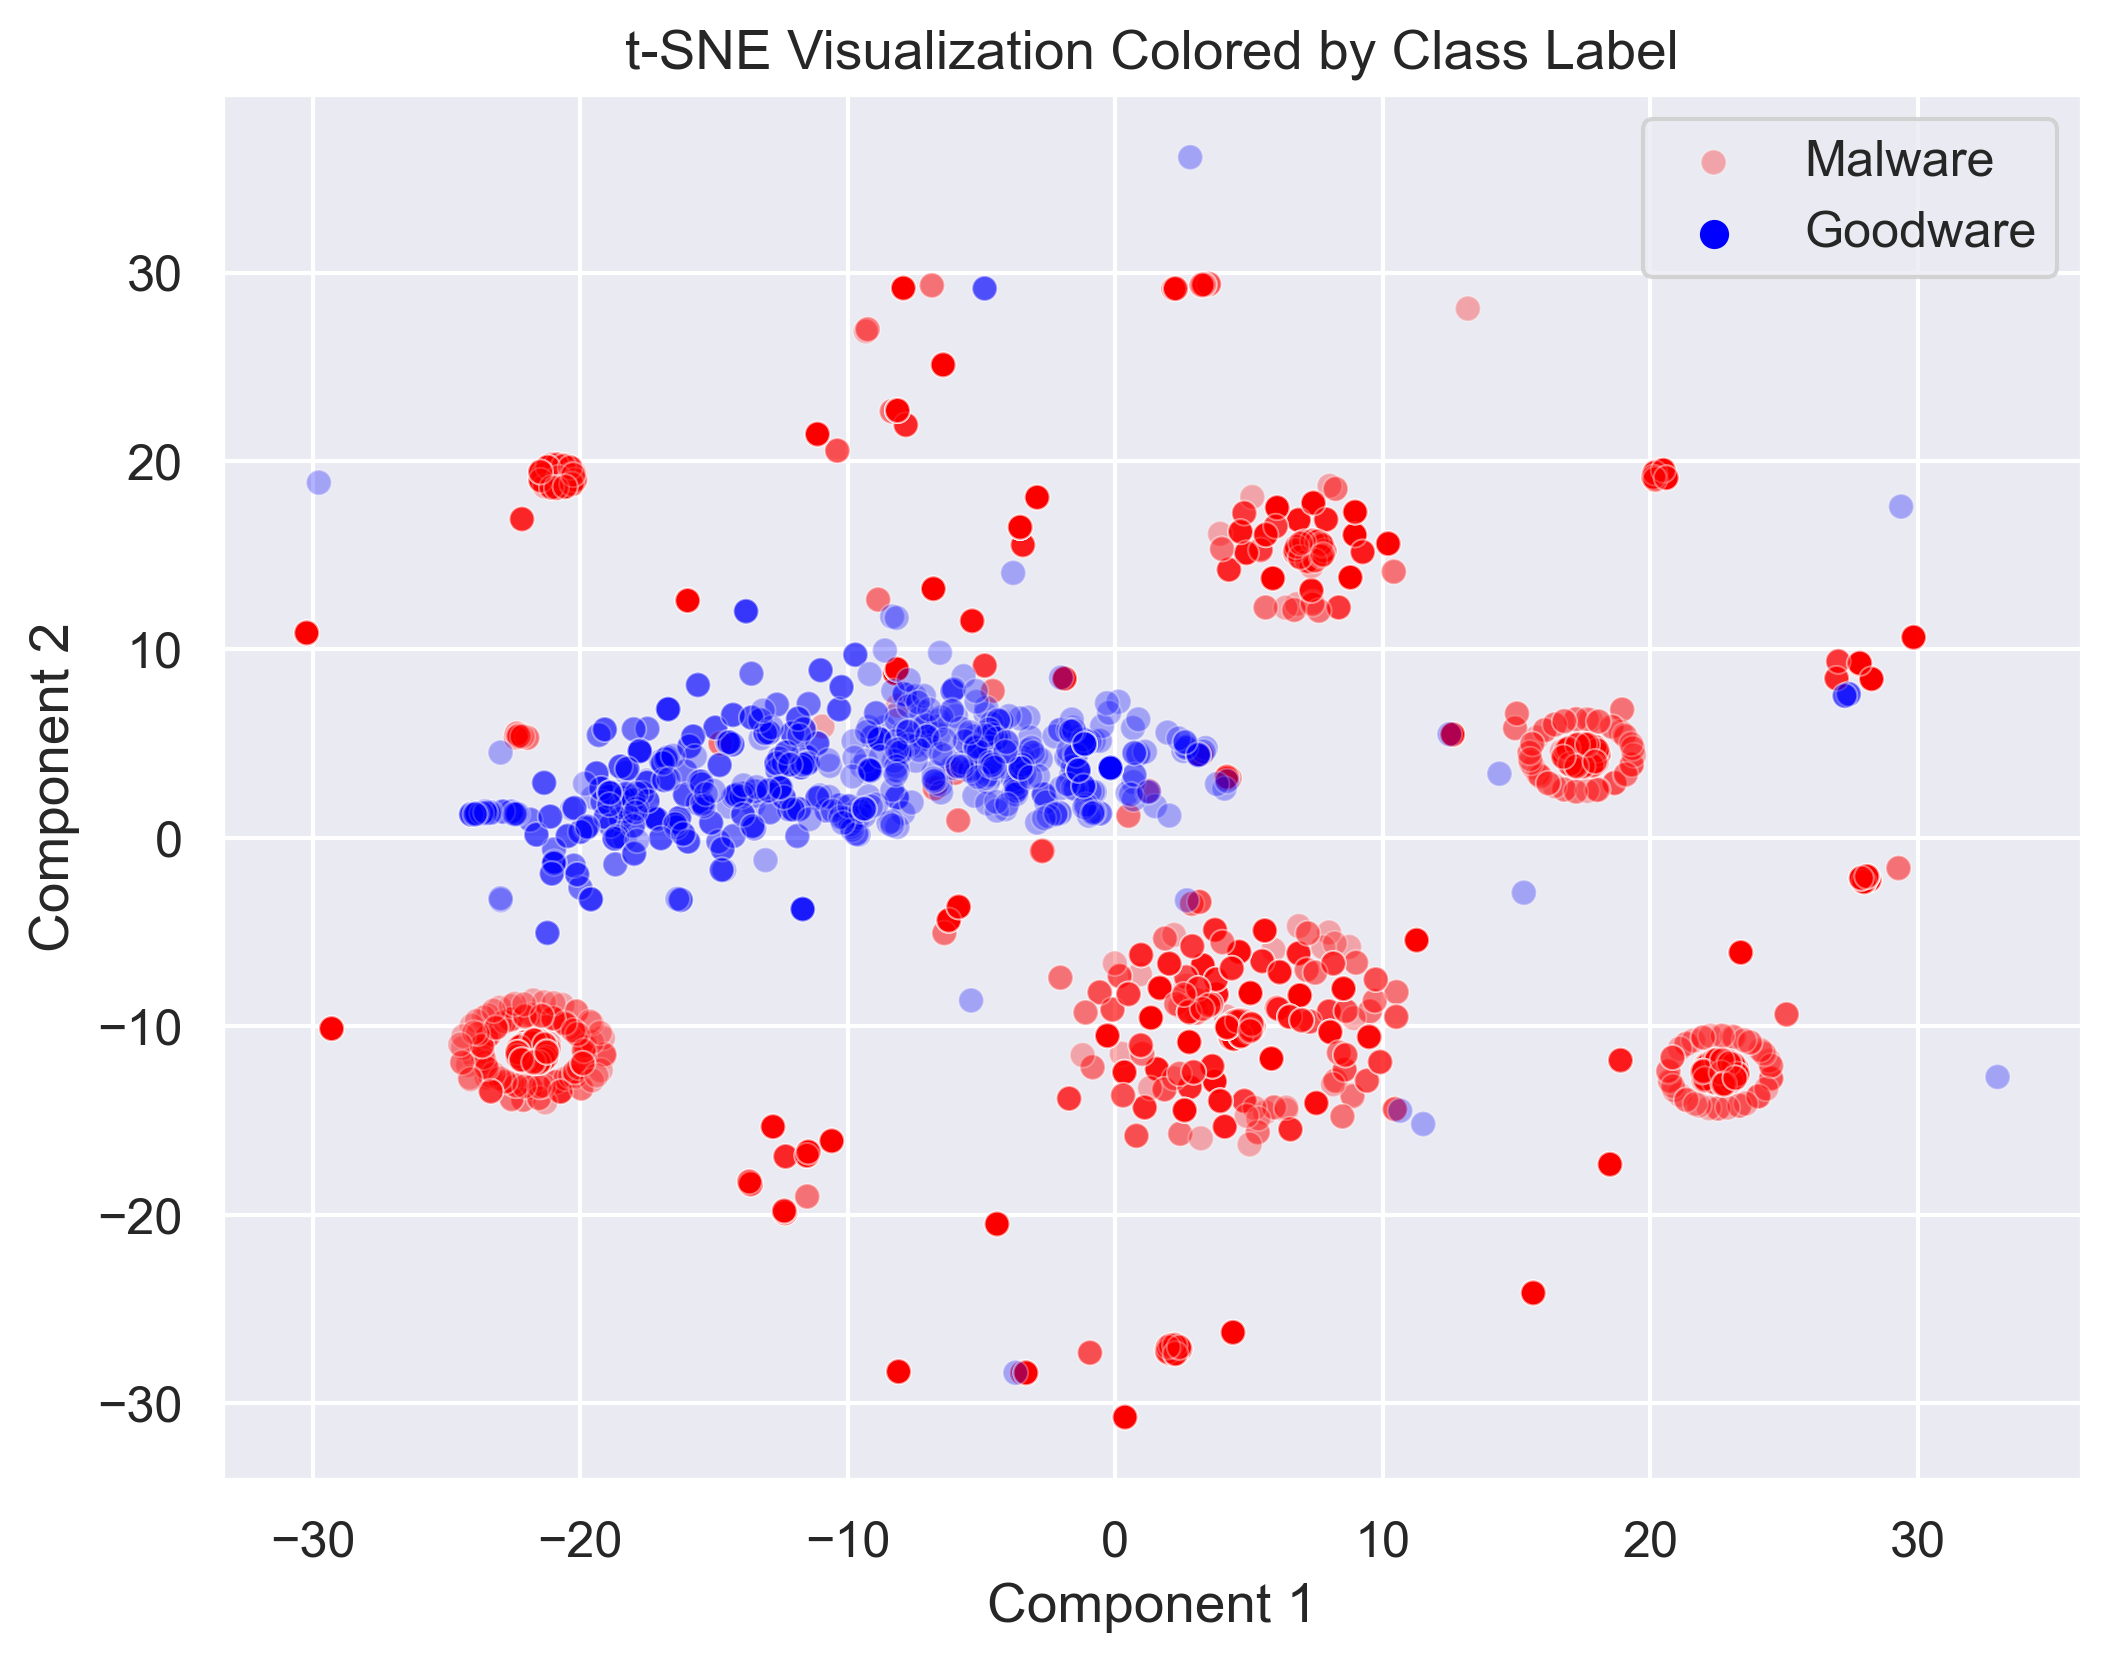

In [28]:
# Plot datapoints and color by class label
plt.figure(figsize=(8,6), dpi=300)
sns.set(style = 'darkgrid', font_scale = 1.1)

sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=y.astype(int),
    palette = {0: 'blue', 1: 'red'},
    legend='full',
    alpha=0.3
)

plt.legend(labels=['Malware', 'Goodware'])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization Colored by Class Label')

In this visualization, we can easily pick out a couple of clusters of malware as well as a distinct grouping of goodware. There are a few scattered datapoints, but most should be easy enough to cluster. The malware samples also appear to be quite densely packed, so DBSCAN should not have a huge issue picking them up. On the other hand, the goodware samples are much less densely packed, so they will be easy to identify as outliers with the right hyperparameters.  
  
# Hyperparameters for DBSCAN
Talking about hyperparameters, how should we go about picking them? And what are the important hyperparameters anyways?  
  
In DBSCAN, epsilon ($\epsilon$) and min_samples are the most important hyperparameters which significantly influence the clustering results. Epsilon ($\epsilon$) is defined as the radius around a data point which DBSCAN uses to count the number of neighboring points and determine whether the given point is a core point, border point, or noise. This essentially defines the neighborhood's size. A small value of epsilon ($\epsilon$) will create more compact clusters, while a larger epsilon ($\epsilon$) may merge clusters or consider more points as noise. Min_samples is the minimum number of data points within the epsilon ($\epsilon$) radius required for a data point to be considered a core point. This determines the density required to form a cluster. A higher value here enforces a higher density requirement, while a lower one will allow for more sparse clusters. With both of these parameters, the density and shape of the clusters can vary drastically. So, it is very important to tune them correctly.  
  
Selecting min_samples is the easier of the two. A general rule of thumb is choosing a value in the range \[dimensions + 1, 2*dimensions\], where dimensions is the dimensionality of your dataset. Our dataset has 241 features, so dimensions = 241. Here, we can just round up and use 250 dimensions and see what happens.  
  
For choosing epsilon ($\epsilon$), there is a popular method which includes using a nearest neighbors model. Initially, we will compute the distances between the points and their *num_features* nearest points. For us, *num_features* is 241, so we simply have to find the distances from every point to its 241 nearest neighbors. To do this, we make use of sklearn's NearestNeighbors model and set *n_neighbors* equal to 241. We also must make sure to set *metric* to 'precomputed' again so we can make use of our gower's distance matrix. Then, using the kneighbors() function, we can get the indices and distances of the 241 nearest neighbors to each point. Next, we just sort the points by the distances in ascending order and plot the distances over the indices with a line plot. At the point where the slope of the curve increases significantly, we place a point (denoted as the elbow point). The distance value for this point is what we will set epsilon ($\epsilon$) to.

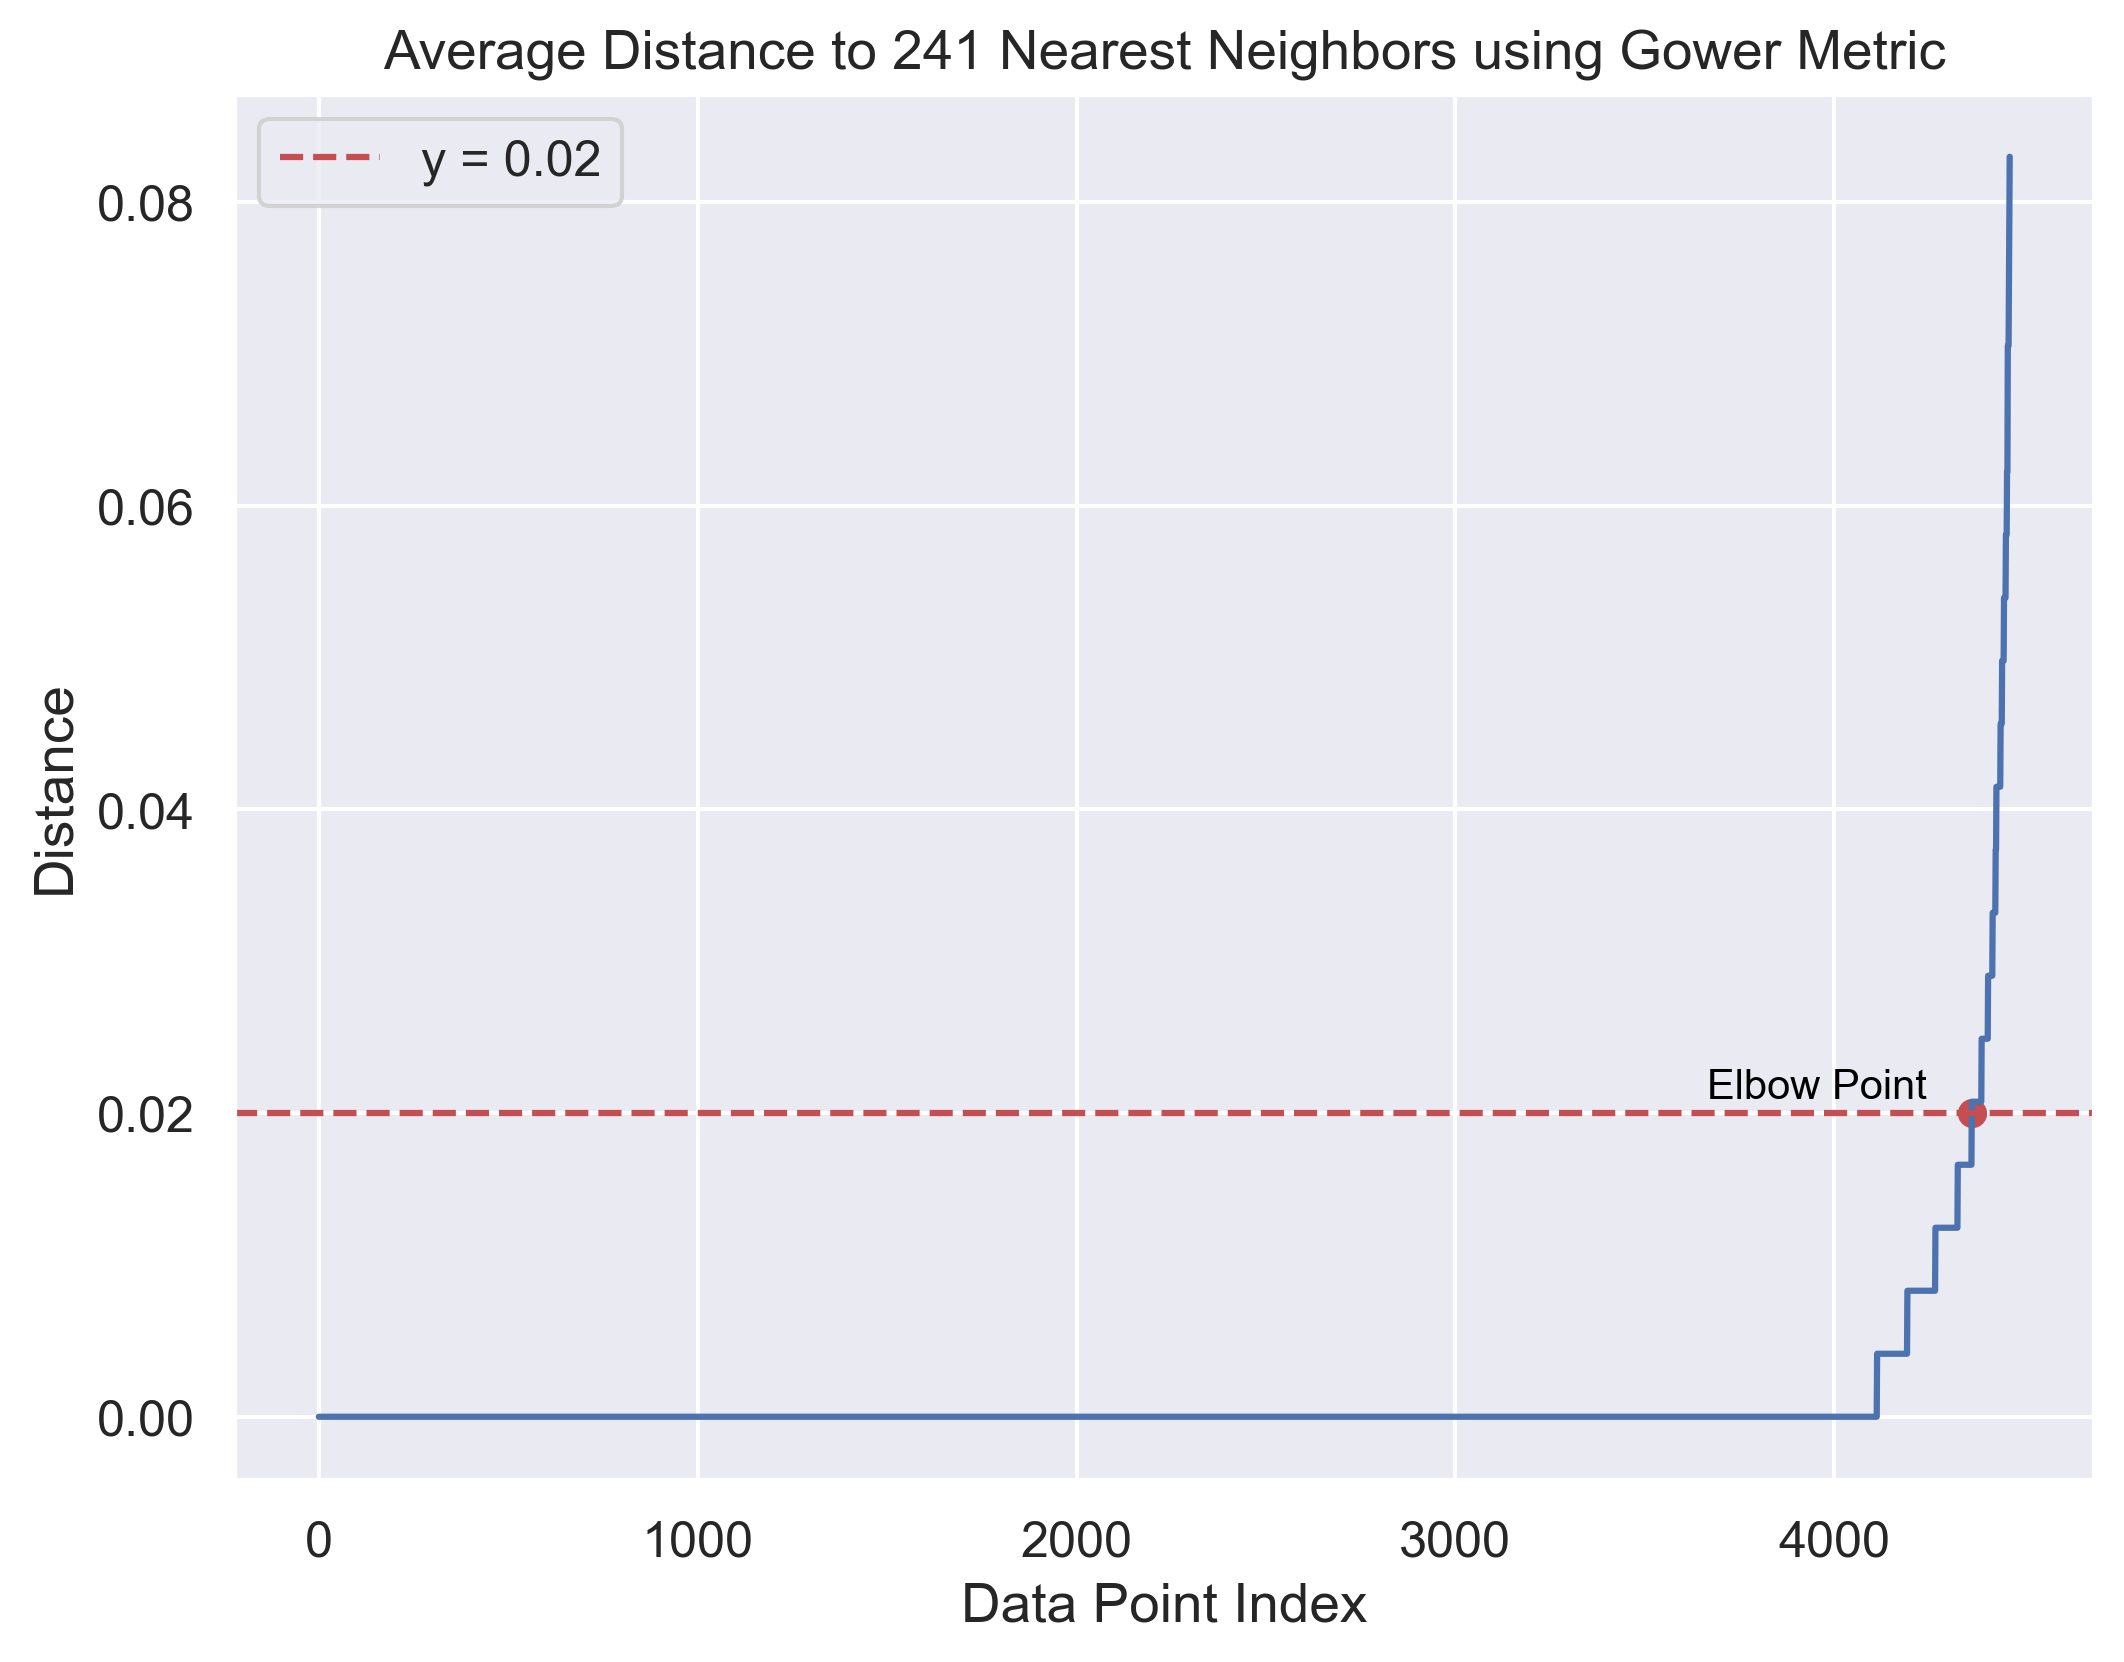

In [30]:
# Selecting epsilon for DBSCAN

# Compute the average distances between points and num_features Nearest points
neighbors = NearestNeighbors(n_neighbors = 241,
                             metric='precomputed').fit(dist_matrix)
distance, idx = neighbors.kneighbors(dist_matrix)

# Sort distance values by ascending
distance = np.sort(distance, axis=0)
distance = distance[:, 1]

# Plot distance over index
    # Set up figure
plt.figure(figsize=(8,6), dpi=300)
sns.set(style = 'darkgrid', font_scale = 1.1)

    # Plot distances and indices
sns.lineplot(x = np.arange(len(distance)),
             y = distance)

    # Plot elbow line and point
plt.axhline(y=0.02, color='r', linestyle='--', label='y = 0.02')
plt.scatter(x = np.argmin(np.abs(distance - 0.02)),
            y = 0.02,
            color = 'r',
            marker = 'o')
plt.text(x = np.argmin(np.abs(distance - 0.02)) - 700,
         y = 0.021,
         s = 'Elbow Point',
         color = 'black',
         fontsize = 10)



    # Finish figure with title and labels
plt.xlabel('Data Point Index')
plt.ylabel('Distance')
plt.title('Average Distance to 241 Nearest Neighbors using Gower Metric')
plt.legend()

Taking a look at this plot, we place our elbow point at $y = 0.02$. Here, the distance is 0.02, so we can set epsilon ($\epsilon$) to 0.02.  
  
# Applying DBSCAN
Now, we have both of our most important hyperparameters for DBSCAN:
- min_samples = 250
- epsilon ($\epsilon$) = 0.02
  
With these hyperparameters, we can now fit a DBSCAN model on our data. To do this, we just create a DBSCAN model, set our hyperparameters (remember to set *metric* to 'precomputed' again), and finally call the fit() function with our distance matrix. After this, we will use that helper function from earlier to see what the cluster labels look like. 

In [33]:
# Run DBSCAN
dbscan = DBSCAN(eps = 0.02,
                min_samples = 250,
                metric='precomputed').fit(dist_matrix)

# Print unique values with counts from dbscan labels   
print_unique_with_counts(dbscan.labels_)

Value: -1, Count: 1680
Value: 0, Count: 388
Value: 1, Count: 1089
Value: 2, Count: 1014
Value: 3, Count: 293


After fitting DBSCAN, we can get our labels with the *label_* learned property. Taking a look at the cluster counts, we can see that DBSCAN picked up a couple clusters and left 1680 samples as outliers (data points which do not fit into any clusters). This does not tell us much, so let's make the same plot from earlier, but color the points by cluster assignments this time. We will color the outliers as blue (since we hope that these represent the goodware), and all other clustered points as red. For this, we can just set up a simple dictionary as a color map.

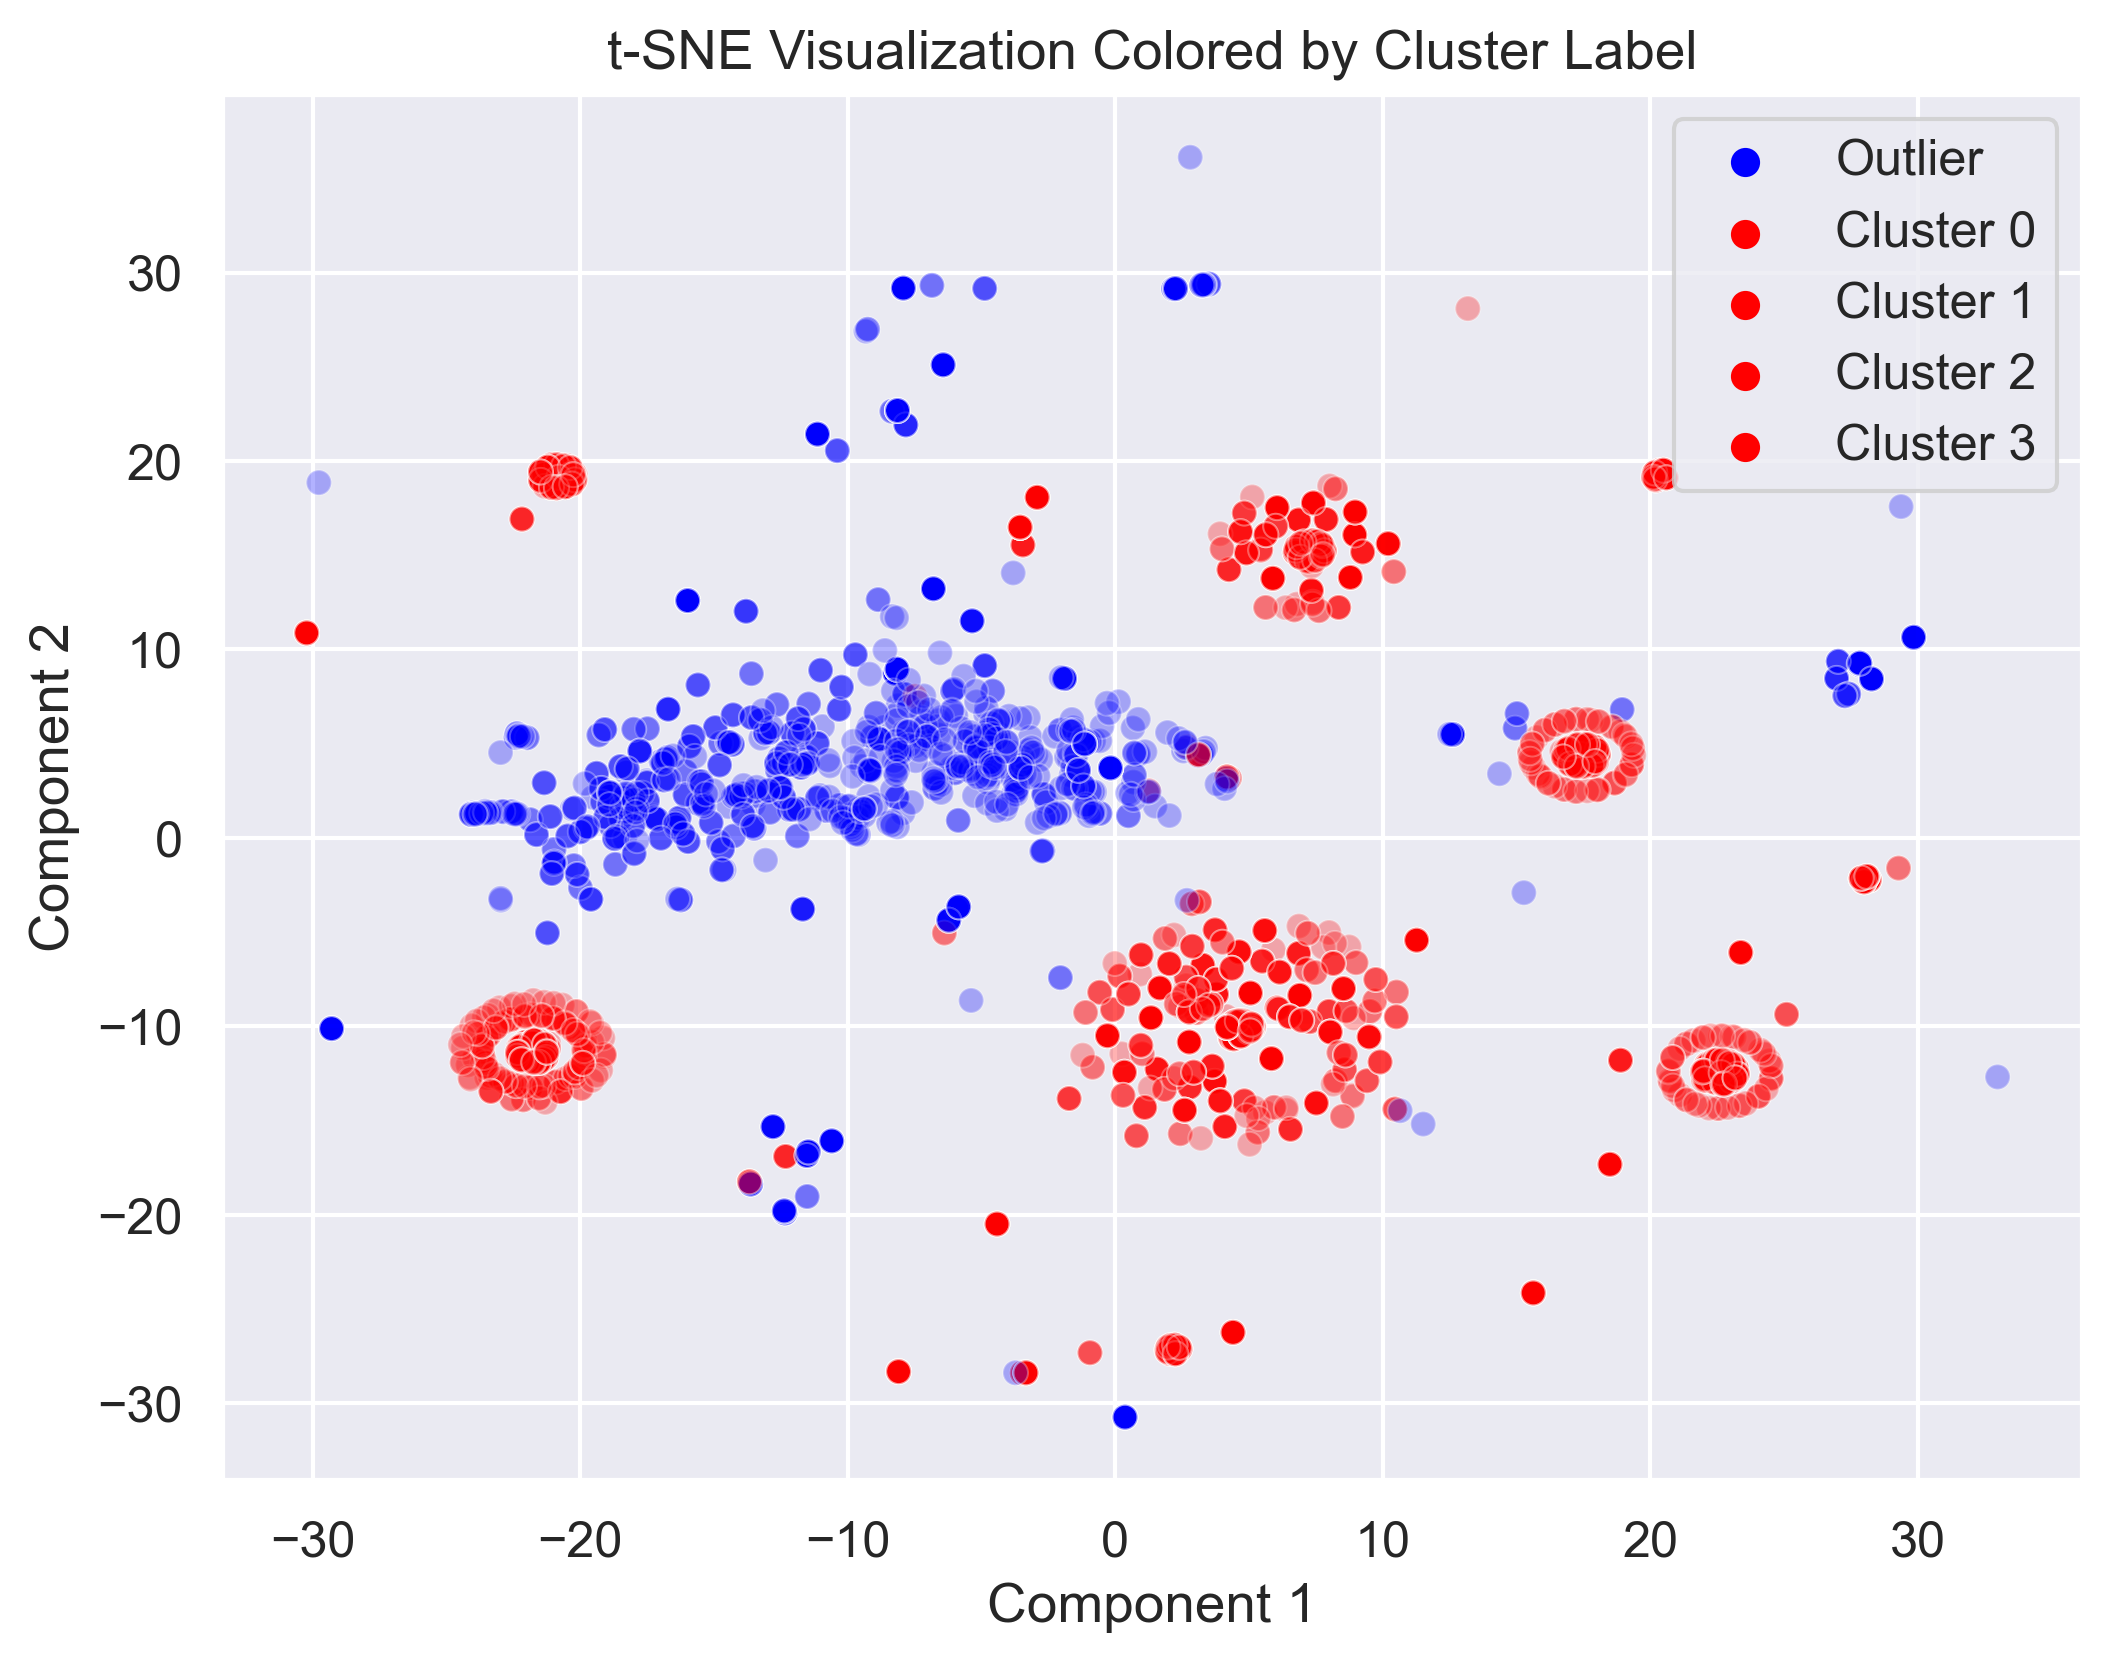

In [34]:
# Set up color map for plot
color_dict = {'Outlier': 'blue'}

# Map every other integer to black
for i in range(4):
    color_dict[f'Cluster {i}'] = 'red' 
    
# Map cluster labels to strings for plot legend
cluster_mapping = {-1: 'Outlier',
                   0: 'Cluster 0',
                   1: 'Cluster 1',
                   2: 'Cluster 2',
                   3: 'Cluster 3'}

cluster_labels = [cluster_mapping[label] for label in dbscan.labels_]
    
# Set up figure
plt.figure(figsize=(8,6), dpi=300)
sns.set(style = 'darkgrid', font_scale = 1.1)

# Plot using tsne and color by cluster labels
sns.scatterplot(x = tsne_results[:,0],
                y = tsne_results[:,1],
                hue = cluster_labels,
                palette = color_dict,
                legend = 'full',
                alpha = 0.3)

# Finish figure styling
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization Colored by Cluster Label')

# Order legend text properly
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0, 2, 3, 4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

From this plot, it seems that DBSCAN was able to cluster most of the malware clusters that we identified earlier. Most of the dense malware clusters have been correctly identified. Also, the sparse cluster of goodware points were also identified as outliers, just as we had hoped. Another thing to note is that most of the sporatic points which can't easily be placed in the clusters have also been labeled as outliers, and not clustered along with the other malwares. This is simply a side-effect of the way we are approaching this task with anomaly detection. Maybe with some more fine-tuning (or a different model type) we could improve this a bit. However, for purposes of this project, this result is actually quite good.  
  
# Evaluation
So, how can we tell how good DBSCAN did at identifying malware versus goodware? Well, going back to how we constructed this project, since our dataset was mostly malware samples, we were looking to cluster those samples and hopefully be able to separate the goodware as outliers. So, we can covert any cluster assignments to the 1 label, for the malware class, and then convert the outlier label (-1) to 0 for the goodware class. After this, we can compare the results with the ground truths from the original class label array (y) and present a typical confusion matrix along with scores for precision, recall, and f1.  
  
So, to start, we will convert our cluster assignments to class labels in just the same way. We can use a direct mapping from a dictionary to do this. We will then print our the class counts again to see what it looks like.

In [35]:
# Convert cluster assignments to class labels
# Outliers are goodware, all other clusters are malware
cluster_assignments = dbscan.labels_
cluster_to_class_mapping = {0: 1,
                            1: 1,
                            2: 1,
                            3: 1,
                           -1: 0}
clusters_mappedTo_classes = np.array([cluster_to_class_mapping[assignment] for assignment in cluster_assignments])

# Print class counts for mapped classes
print_unique_with_counts(clusters_mappedTo_classes)

Value: 0, Count: 1680
Value: 1, Count: 2784


Looks good! We now have two classes from our cluster labels. The proportions are not exactly the same as we saw in the original dataset, but they are not too far off. We seem to have missed some malwares, but if this problem was easy to solve, then we wouldn't still be trying to find a way to fix it now.  
  
We can now treat these converted cluster labels as something like a prediction and create a confusion matrix with sklearn's confusion_matrix() function, passing in the new labels as well as the ground truths from the original dataset (y).

Precision: 0.998
Recall: 0.779
F1: 0.875


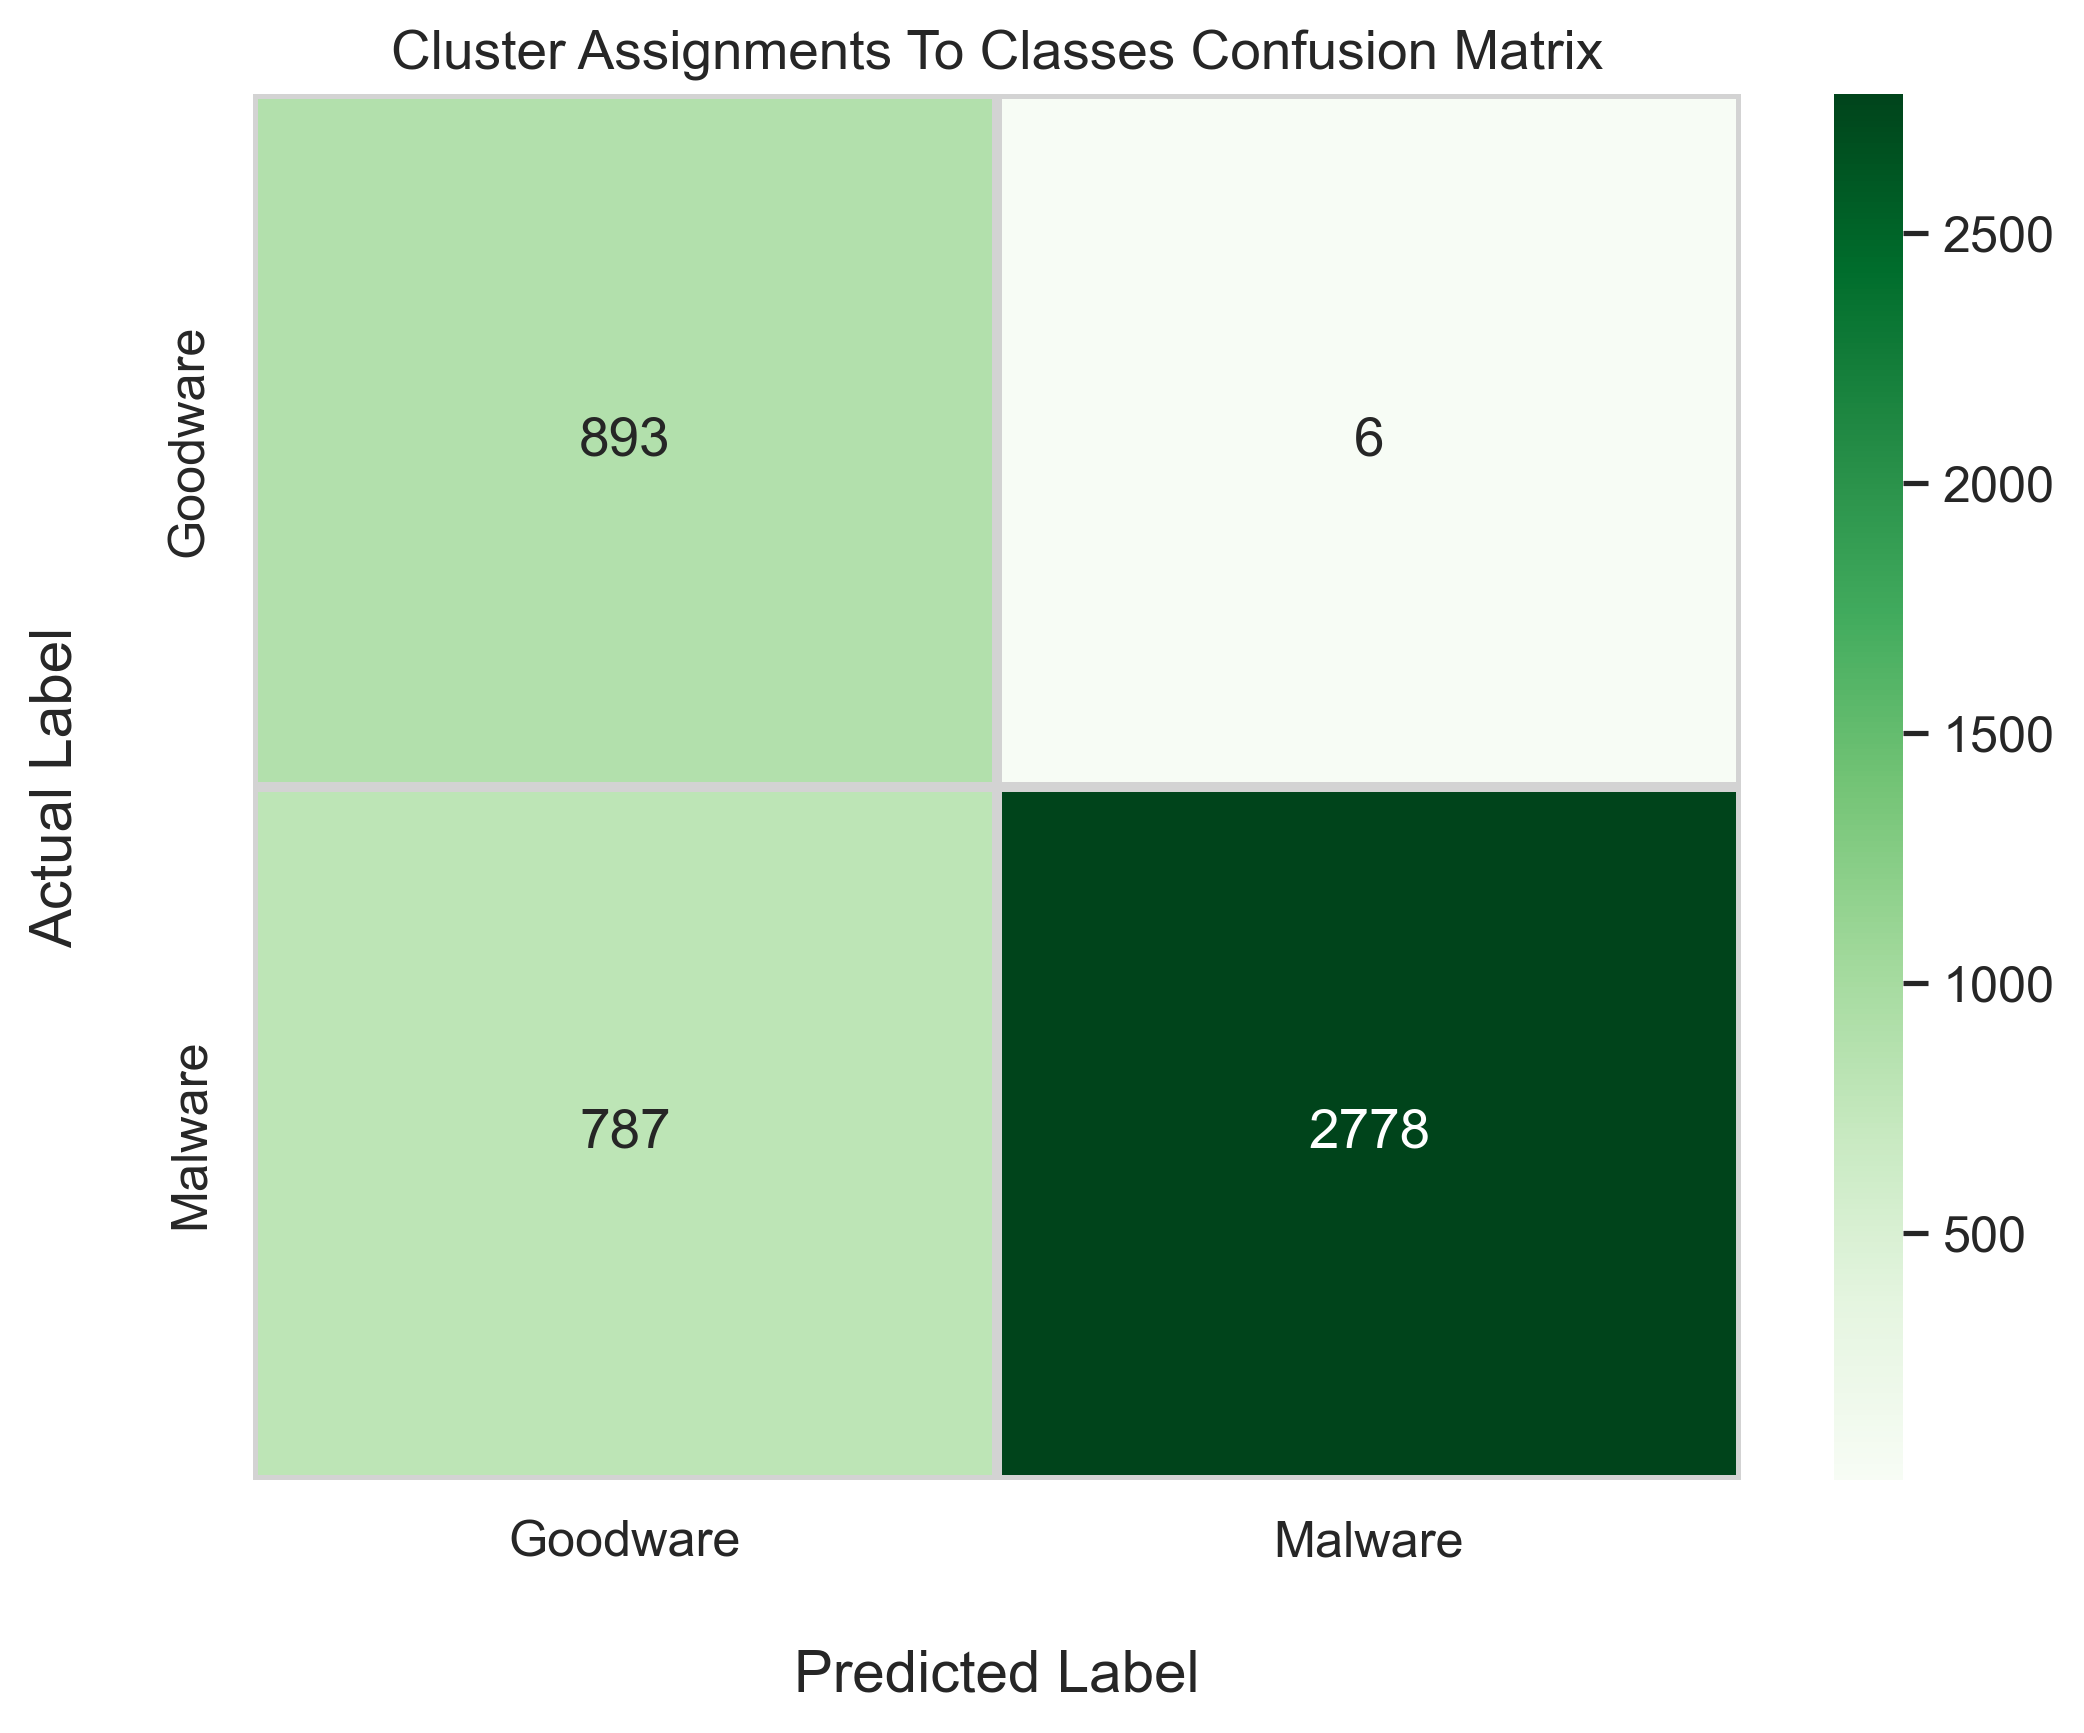

In [36]:
# Make Confusion Matrix
y_pred = clusters_mappedTo_classes
cm = sk.metrics.confusion_matrix(y, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Goodware', 'Malware'],
                     columns = ['Goodware', 'Malware'])

# Print evaluation metrics
print(f'Precision: {sk.metrics.precision_score(y, y_pred):.3f}')
print(f'Recall: {sk.metrics.recall_score(y, y_pred):.3f}')
print(f'F1: {sk.metrics.f1_score(y, y_pred):.3f}')

# Display Confusion Matrix
plt.figure(figsize=(8,6), dpi=300)
sns.set(font_scale = 1.1)
ax = sns.heatmap(cm_df, annot=True, fmt='d', linewidths=2, linecolor='#d3d3d3', cmap='Greens')
ax.set_title('Cluster Assignments To Classes Confusion Matrix')
ax.set_xlabel("Predicted Label", fontsize=14, labelpad=20)
ax.set_ylabel("Actual Label", fontsize=14, labelpad=20);

Taking a look at the precision, recall, and f1 scores, we see that our precision score is almost perfect. This means that the samples which DBSCAN labeled as goodwares (outliers or anomalies) were actually goodwares 99.8 percent of the time. In other words, we only misclassified goodware as malware 6 total times. Next, regarding recall, we have a score of 0.779. This essentially means that we were able to correctly identify 77.9% of malware samples. Not bad! Unfortunately, on the other side, we missed 22.1% of malware instances. These are the samples which were not clustered along with other malware samples, and thus were treated as outliers (or goodwares). Finally, we have a decent f1 score of 0.875, which combines both precision and recall into a single score. In conclusion, using anomoly detection worked quite well for identifying android malware.

# Conclusion
The exploration of using DBSCAN for anomaly detection, particularly in the context of malware identification, reveals a promising perspective on enhancing cybersecurity in the modern day and age. Leveraging the power of DBSCAN, this project has just touched the surface on what types of problems can be approached via outlier detection. Working with the TUNADROMD dataset today, we have been able to demonstrate exactly how effective these machine learning techniques can discern subtle patterns indicative of potential threats in android softwares. Notably, we were able to correctly identify 77.9% of malware samples in our dataset (woooo!). As we navigate this crossroad between machine learning and cybersecurity, this project serves to empower machine learning practitioners and enthusiasts alike with the conceptual knowledge and skills required to fortify the difital world against the ever-evolving landscape of cyber threats. If you have made it this far, I commend you for your persistence. I hope you enjoyed this post and learned something valuable along the way. To sign off, thank you for your time and, most importantly, you've done well today friend.

(\\(\\  
(-.-)  
o_(")(")